In [1]:
from pulser import Pulse, Sequence, Register
from pulser_simulation import QutipEmulator
from pulser.devices import Chadoq2
from pulser.waveforms import InterpolatedWaveform
import matplotlib.pyplot as plt
import numpy as np
import igraph
from itertools import combinations
from collections import defaultdict
from scipy.optimize import minimize
import networkx as nx
from scipy.spatial.distance import pdist, squareform

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Solving the Max-cut problem with Neutral Atoms

### **Victor Onofre**

# Part I: Max-cut problem 

The goal of the max-cut problem is to:

> **Have as many cut edges as possible. Where an edge is cut if its endpoints have different colors**

The output is a "2-coloring" of $V$: Each vertex is designated a color (examples: blue or red)

The maximum cut can be formaulated as an optimization problem:

$$ \max_{s}\frac{1}{2} \sum_{ij \in E}  (1-s_{i}s_{j}), \quad s_{i} \in \{-1 , +1 \}$$

> Same sign: No edge is cut (no contribution to the objective function) $\rightarrow \frac{1}{2} (1-s_{i}s_{j}) = 0$

> Different sign: An edge is cut (contribution to the objective function) $\rightarrow \frac{1}{2} (1-s_{i}s_{j}) = 1$

## Max cut as a QUBO problem

The maximum cut problem can be naturally transformed into the Quadratic unconstrained binary optimization (QUBO) model as follows: 

If we look for a maximum cut in our graph, then we are looking for a way to split the nodes into two groups so that there are as many edges as possible between the groups.We can define a binary variable $x_{i}$ for each node:

> $x_{i} = 0 \rightarrow$ The node is in the first subset 

> $x_{i} = 1 \rightarrow$ The node is in the second subset 

Defining the edge_score(i,j) as 1 if the two nodes are in a different subset, 0 otherwise, we can build the followin table: 


| $x_{i}$  | $x_{j}$  |  edge_score(i,j) |  
|---|---|---|
| 0  | 0  | 0  |  
| 0  | 1  | 1  |
| 1  | 0  | 1  |
| 1  | 1  | 1  |

The edge_score is define as $x_{i} + x_{j} - 2 x_{i} x_{j}$. Then for the entire graph, the objective funtion can be written as:

$$ \max \sum_{(i,j) \in E} (x_{i} + x_{j} - 2x_{i}x_{j}) $$

Multiplying by -1 to the convert to a minimization problem: 

$$ \min \sum_{(i,j) \in E} (- x_{i} - x_{j} + 2x_{i}x_{j}) $$

We can build a function to build the QUBO matrix for an arbitrary graph:

In [3]:
def build_qubo_matrix(graph):
    
    #Number of nodes in the graph
    num_nodes = len(graph.nodes) 
    
    # Initialize our QUBO matrix
    Q_matrix = np.zeros((num_nodes, num_nodes))
    
    # Update Q matrix for every edge in the graph
    for i, j in graph.edges:
        Q_matrix[i][i]+= -1
        Q_matrix[j][j]+= -1
        Q_matrix[i][j]+= 2
        
    return Q_matrix

##  Examples of solutions to the max-cut problem:

### Example 1

In the triangular graph the solution to the max-cut problem is:

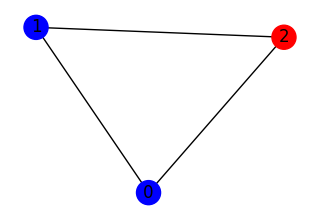

In [4]:
Graph_Example_1 = nx.Graph()
Graph_Example_1.add_edges_from([[0,1],[1,2],[0,2]])

plt.figure(figsize=(3,2)) 
nx.draw(Graph_Example_1,with_labels=True,node_color = ['b','b','r'])

Where we a maximum of $2$ cuts. If we assign a string to the colors in the graph we can represent this solution as: $001$. Other combinations with the same number of cuts are $100$ and $010$. 
> Where $0$ is the node blue and $1$ the node is red

If $x$ is one of the binary solutions, the QUBO matrix will give us the total cuts as follows: 

$$ f_{Q} (x) = x^{T}Q x $$

In [5]:
Q_matrix_triangular = build_qubo_matrix(Graph_Example_1)
Q_matrix_triangular

array([[-2.,  2.,  2.],
       [ 0., -2.,  2.],
       [ 0.,  0., -2.]])

In [6]:
x = np.array([0,1,0])
cost = x.T @ Q_matrix_triangular @ x
cost

-2.0

## Brute force solution 

In [7]:
def brute_force(qubo_matrix):
    """Brute force solver for the QUBO problem

    Args:
        qubo_matrix: QUBO matrix representing the problem 

    Returns:
        sort_solutions: Dictionary with the solutions in order
    """
    
    
    
    bitstrings = [np.binary_repr(i, len(qubo_matrix)) for i in range(2 ** len(qubo_matrix))]
    costs = []
    
    # this takes exponential time with the dimension of the QUBO
    
    for b in bitstrings:
        z = np.array(list(b), dtype=int)
        cost = z.T @ qubo_matrix @ z
        costs.append(cost)
        zipped = zip(bitstrings, costs)
    
    sort_solutions = sorted(zipped, key=lambda x: x[1])
    
    return sort_solutions

In [8]:
brute_force(Q_matrix_triangular)[:4]

[('001', -2.0), ('010', -2.0), ('011', -2.0), ('100', -2.0)]

# Part II: Encoding a graph using a neutral atoms device

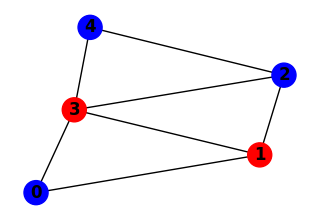

In [9]:
Graph_Example_encoding  = nx.Graph()
Graph_Example_encoding .add_edges_from([[0,1],[1,2], [1,3], [0,3],[3,2],[3,4],[2,4]])

plt.figure(figsize=(3,2)) 
nx.draw(Graph_Example_encoding ,with_labels=True,node_color = ['b','r','b','r','b'],font_weight='bold')

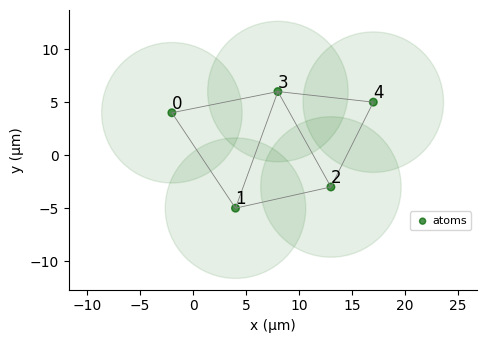

In [10]:
qubits3 = {'0': (-2,4), '1': (4,-5), '2': (13, -3), '3': (8,6), '4': (17,5)} #, '3': (8,6), '4': (-8, 6)
reg3 = Register(qubits3)
reg3.draw(
    blockade_radius=Chadoq2.rydberg_blockade_radius(1.0),
    draw_graph=True,
    draw_half_radius=True
)

In [11]:
Q_example_encoding = build_qubo_matrix(Graph_Example_encoding)
Q_example_encoding

array([[-2.,  2.,  0.,  2.,  0.],
       [ 0., -3.,  2.,  2.,  0.],
       [ 0.,  0., -3.,  2.,  2.],
       [ 0.,  0.,  0., -4.,  2.],
       [ 0.,  0.,  0.,  0., -2.]])

## Create register as an optimization process

In [12]:
def evaluate_mapping(new_coords, *args):
    """Cost function to minimize. Ideally, the pairwise
    distances are conserved"""
    Q, shape = args
    new_coords = np.reshape(new_coords, shape)
    new_Q = squareform(
        Chadoq2.interaction_coeff/ pdist(new_coords) ** 6
    )
    return np.linalg.norm(new_Q - Q)

def create_coordinates(qubo_matrix,
                    optimizer= "COBYLA",  
                    scale_factor =3):
    """Creation of coordinates for the register in the quantum device 
       given a QUBO matrix

    Args:
        qubo_matrix: QUBO matrix representing the problem 
        optimizer: Minimizer to use from scipy. Default COBYLA
        scale_factor: Factor to scale the QUBO matrix. Default 3

    Returns:
        coordinates: The coordinates for the register
    """
    
    size_matrix = len(qubo_matrix)
    
    shape = (size_matrix, 2)
    costs = []
    np.random.seed(0)
    
    x0 = np.random.random(shape).flatten()
    
    res = minimize(
        evaluate_mapping,
        x0,
        args=(qubo_matrix*scale_factor, shape),
        method=optimizer,
        tol=1e-6,
        options={"maxiter": 200000},
    )
    
    coordinates = np.reshape(res.x, (size_matrix, 2))

    return coordinates

In [13]:
coords_example = create_coordinates(Q_example_encoding)
coords_example

array([[ 5.24411836, 12.9150815 ],
       [ 8.71185464,  2.43707612],
       [ 1.37077413, -5.80555067],
       [-2.09555962,  4.67203285],
       [-9.43722001, -3.56925211]])

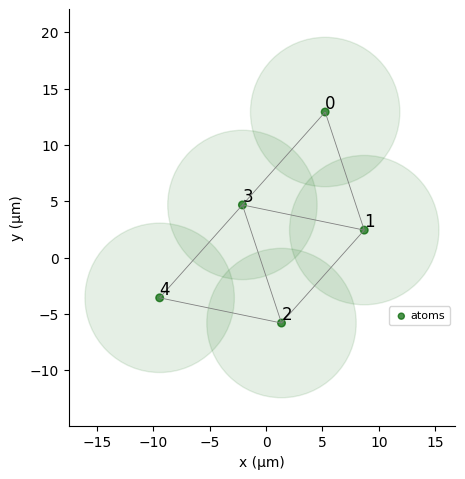

In [14]:
qubits_example = dict(enumerate(coords_example))
reg_example = Register(qubits_example)
reg_example.draw(
    blockade_radius=Chadoq2.rydberg_blockade_radius(1.0),
    draw_graph=True,
    draw_half_radius=True,
)

# Part III: Quantum Approximate Optimization Algorithm (QAOA ) with Neutral Atoms

In [15]:
def define_sequence(register,
                    p_layers):
    """Definition of parametrized sequence to use for the QAOA.

    Args:
        register: The atomic register representing the problem in the quantum device
        p_layers: Number of layers for the QAOA

    Returns:
        seq: parametrized sequence
    """
    
    # Parametrized sequence
    seq = Sequence(register, Chadoq2)
    seq.declare_channel('ch0', 'rydberg_global')
    
    beta_list = seq.declare_variable('beta_list', size = p_layers)
    gamma_list = seq.declare_variable('gamma_list', size = p_layers)
    
    if p_layers == 1:
        beta_list = [beta_list]
        gamma_list = [gamma_list]
        
    for beta, gamma in zip(beta_list, gamma_list):
        beta_pulse = Pulse.ConstantPulse(1000*beta, 1.0, 0, 0)
        gamma_pulse = Pulse.ConstantPulse(1000*gamma, 0 , 1.0, 0)
        
        seq.add(beta_pulse, 'ch0')
        seq.add(gamma_pulse, 'ch0')
    
    seq.measure('ground-rydberg')
    
    return seq

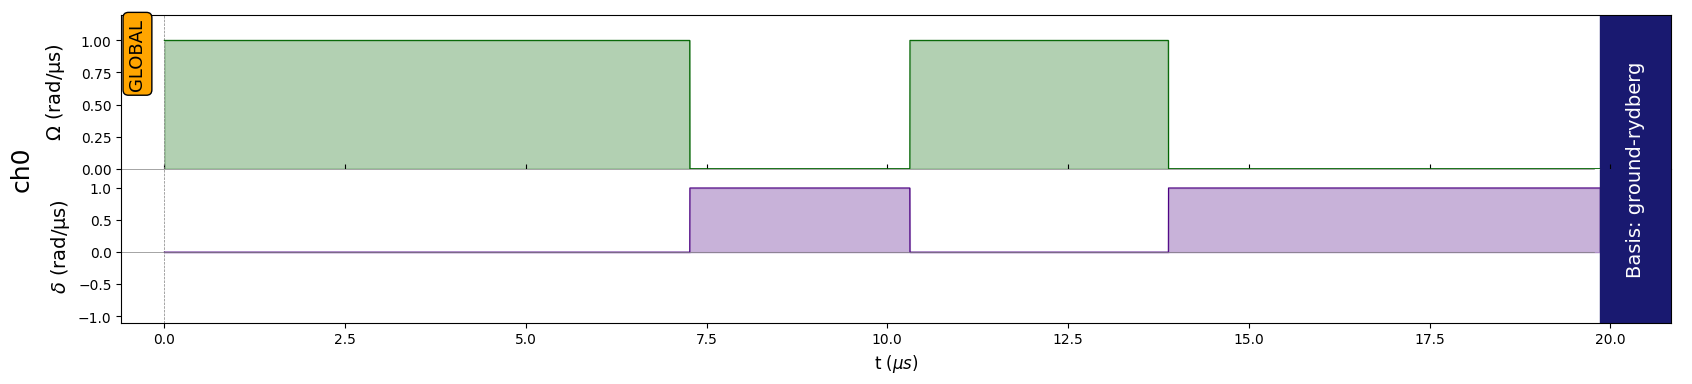

In [16]:
# QAOA with random parameters

sequence = define_sequence(reg_example,p_layers=2)

np.random.seed(123) # Ensures reproducibility of the tutorial

random_beta = np.random.uniform(1,10, 2)
random_gamma = np.random.uniform(1,10,2)

assigned_seq = sequence.build(beta_list = random_beta, gamma_list = random_gamma)

assigned_seq.draw()

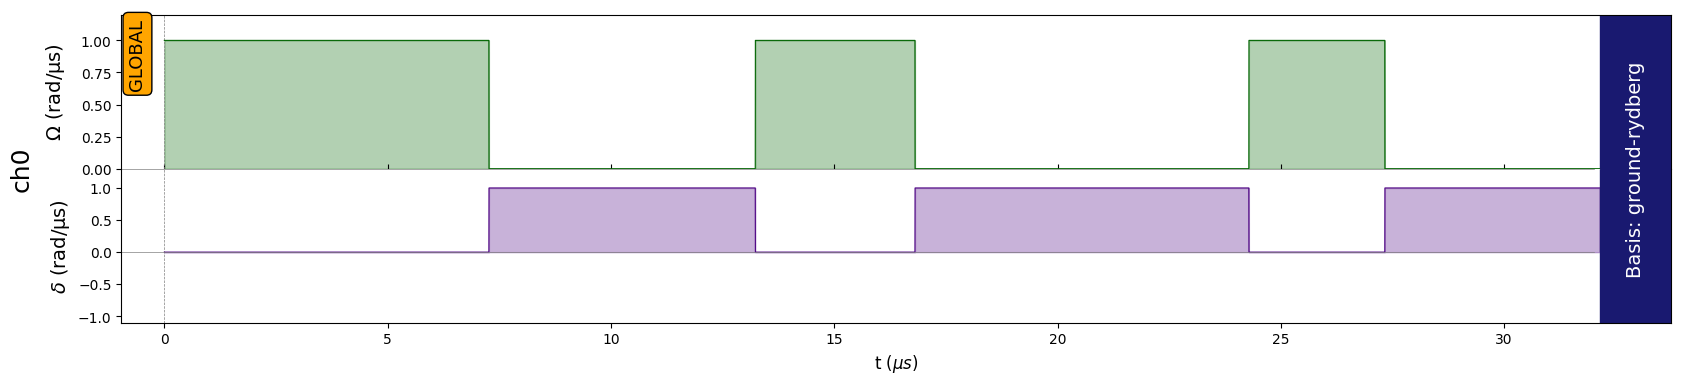

In [17]:
sequence = define_sequence(reg_example,p_layers=3)

np.random.seed(123) # Ensures reproducibility of the tutorial

random_beta = np.random.uniform(1,10, 3)
random_gamma = np.random.uniform(1,10,3)

assigned_seq = sequence.build(beta_list = random_beta, gamma_list = random_gamma)

assigned_seq.draw()

In [18]:
# Building the quantum loop

def quantum_loop(parameters, 
                 sequence, 
                 p_layers):
    """Simulation of the sequence in the quantum device

    Args:
        parameters: Parameters used in the sequence
        sequence: Definition of the sequence given a registers
        p_layers: Number of layers for the QAOA

    Returns:
        counts:Distribution of the samples
    """
    
    params = np.array(parameters)
    beta_params, gamma_params = np.reshape(params.astype(int), (2, p_layers))
    
    assigned_seq = sequence.build(beta_list = beta_params, gamma_list = gamma_params)
    
    sim = QutipEmulator.from_sequence(assigned_seq, sampling_rate = 0.01)
    res = sim.run()
    
    #Samples from the state vector that results from running the simulation 
    counts = res.sample_final_state(N_samples = 6000) 

    return counts

def plot_distribution(count_dist):
    count_dist = dict(sorted(count_dist.items(), key = lambda item: item[1], reverse = True))
    plt.figure(figsize= (6,4))
    plt.xlabel('bitstings')
    plt.ylabel('counts')
    plt.bar(count_dist.keys(), count_dist.values(), width = 0.5)
    plt.xticks(rotation = 'vertical')
    plt.show()

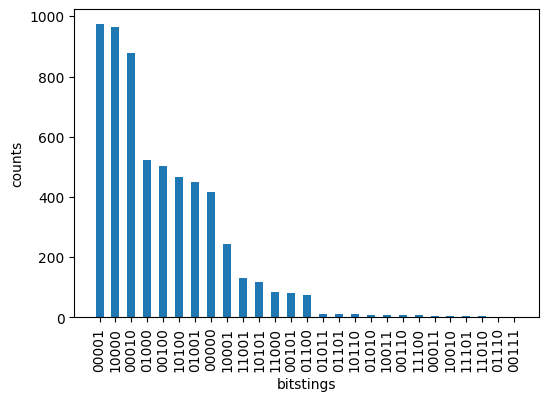

In [21]:
# QAOA with random parameters

np.random.seed(123) # Ensures reproducibility of the tutorial

random_beta = np.random.uniform(1,10, 2)
random_gamma = np.random.uniform(1,10,2)

sequence1 = define_sequence(reg_example, p_layers = 2 )

random_counts = quantum_loop(np.r_[random_beta, random_gamma],sequence1 ,  p_layers = 2 )
plot_distribution(random_counts)

# Part III: Optimization

In [22]:
def get_cost(bitstring, Q):
    """Get the cost of the problem 

    Args:
        Q: QUBO matrix
        bitstring: Solution in bitstring format

    Returns:
        cost
    """
    z = np.array(list(bitstring), dtype=int)
    cost = z.T @ Q @ z
    return cost


def get_cost_average(counts_distr, Q):
    """Get the average cost of the problem 

    Args:
        counts_distr: Counts distribution from the sequence simulation
        Q: QUBO matrix

    Returns:
        Average cost
    """
    cost = sum(counts_distr[key] * get_cost(key, Q) for key in counts_distr)
    return cost / sum(counts_distr.values())  # Divide by total samples



def func_to_min(param, *args):
    """Function to minimize

    Args:
        param: Parameters beta and gamma for the sequence
        args: QUBO matrix, sequence and p layers

    Returns:
        Average cost
    """
    Q, sequence, p_l = args
    #sequence  = args[0][1]
    #p_l = args[0][2]
    C = quantum_loop(param, sequence , p_l)
    cost = get_cost_average(C, Q)
    return cost

In [41]:
def QAOA_solver_for_max_cut(qubo_matrix, 
                            register, 
                            function_to_minimize, 
                            p_layers,
                            optimizer_="COBYLA"):
    """Function to minimize

    Args:
        qubo_matrix: QUBO matrix representing the problem 
        register: The atomic register representing the problem in the quantum device
        function_to_minimize: Function representing the problem to minimize
        p_layers: Number of layers for the QAOA
        optimizer_: Minimizer to use from scipy. Default COBYLA

    Returns:
        optimal_parameters
    """
    
    scores = []
    params = []
    sequence = define_sequence(register,p_layers )
    
    for repetition in range(10):
        random_beta = np.random.uniform(1, 10, p_layers)
        random_gamma = np.random.uniform(1, 10, p_layers)
        
        try:
            res = minimize(
                function_to_minimize,
                args = (qubo_matrix,sequence,p_layers),
                x0 = np.r_[random_beta, random_gamma],
                method =  optimizer_, # 'Nelder-Mead'
                tol = 1e-5,
                options = {'maxiter':1000},
            )
            #print(res.fun)
            scores.append(res.fun)
            params.append(res.x)
            
            optimal_parameters = params[np.argmin(scores)]
        except Exception as e:
            pass
        
    return optimal_parameters 

In [42]:
def plot_solution(graph, Q_matrix, optimal_parameters, register, p_layers):
    
    sequence = define_sequence(register,p_layers )
    optimial_count_dict = quantum_loop(optimal_parameters,  sequence , p_layers)
    best_solution = max(optimial_count_dict, key=optimial_count_dict.get)
    colors = ['b' if best_solution[node] == '0' else 'r' for node in graph] # Define the colors of the nodes for the best solution
    best_cut = get_cost(best_solution, Q_matrix)
    print(f"Best solution: {best_solution} with {-best_cut} cuts")
    
    #plot_distribution(optimial_count_dict)
    plt.figure(figsize=(3,2)) 
    nx.draw(graph,with_labels=True, node_color = colors,font_weight='bold')

In [43]:
opt_parameters = QAOA_solver_for_max_cut(Q_example_encoding,
                                       reg_example, 
                                       func_to_min , 
                                       p_layers = 4)

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.
capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.
capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


In [44]:
opt_parameters

array([ 6.03931784, 10.41340864,  6.79633473,  9.57162394,  9.89517964,
        2.14107592,  3.15641723,  1.81434973])

Best solution: 01001 with 5.0 cuts


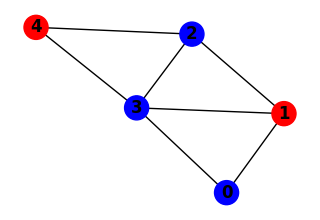

In [45]:
plot_solution(Graph_Example_encoding , 
              Q_example_encoding,
              opt_parameters,
              reg_example,
              p_layers = 4)

In [40]:
brute_force(Q_example_encoding)[:5]

[('00110', -5.0),
 ('01001', -5.0),
 ('01010', -5.0),
 ('01011', -5.0),
 ('10100', -5.0)]

## References

[1] https://arxiv.org/abs/1411.4028

[2] https://www.cs.umd.edu/class/fall2018/cmsc657/projects/group_16.pdf

[3] https://ieeexplore.ieee.org/document/8939749

[4] https://www.mustythoughts.com/quantum-approximate-optimization-algorithm-explained